In [51]:
# !pip install mlxtend

In [52]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      RandomForestClassifier as RC, 
      GradientBoostingClassifier as GBC)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold as KF
from sklearn.model_selection import StratifiedKFold as SKF
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      ShuffleSplit)
from sklearn.decomposition import PCA
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting Malignancy

Accurately determining whether a tumor is benign or malignant is extrememly important in cancer diagnosis and treatment planning.  
This project explores a Kaggle dataset taken from a UC Irvine study of breast cancer containing various characteristics of cell nuclei present in breast tissue, such as texture, smoothness, and symmetry to develop a machine learning model that can make this classification.

By applying data cleaning, feature selection, and predictive modeling techniques, the goal is to uncover patterns that support faster, more reliable diagnoses using data-driven insights.

In [53]:
data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Overview

The dataset contains 569 observations and 31 features, primarily consisting of numerical variables that describe various characteristics of cell nuclei present in digitized images of breast masses.  
These features include metrics like radius, texture, perimeter, area, and smoothness.

The target variable is categorical:  
- `"M"` indicates a malignant tumor  
- `"B"` indicates a benign tumor

In [54]:
X = data.drop(columns={"diagnosis"})
y = data["diagnosis"]

## Feature Selection

To reduce overfitting and improve model performance, we used cross-validation in combination with three models: Logistic Regression, K-Nearest Neighbors, and Random Forest. This is to identify the most important features for predicting tumor malignancy.

We chose forward selection as our feature selection method to reduce computation time, since the dataset includes a relatively large number of features.  
When performing forward selection, we evaluated model performance using **recall** as the scoring metric. In the context of cancer diagnosis, recall is especially important since it's better to flag a benign tumor as malignant (a false positive) than to miss a malignant one (a false negative) that could become life-threatening.

In [55]:
model = LogisticRegression(max_iter=1000)
sfs = SFS(estimator=model, k_features='best', forward=True, scoring="recall", cv=5, n_jobs=-1)
sfs.fit(X, y)
selected_featuresLog = sfs.k_feature_names_  

In [56]:
model2 = RC()

sfs2 = SFS(estimator=model2, k_features='best', forward=True, scoring='recall', cv=5, n_jobs=-1)
sfs2.fit(X, y)
selected_featuresRFC = sfs2.k_feature_names_  

In [ ]:
# # ERROR - FIX
# model3 = KNN()

# sfs3 = SFS(estimator=model3, k_features='best', forward=True, scoring="recall", cv=5)
# sfs3.fit(X, y)
# selected_featuresKNN = sfs3.k_feature_names_  

In [59]:
lsts = [[] for _ in selected_featuresLog]
for i, feature in enumerate(selected_featuresLog):
    lsts[i] = feature
log_X= data[lsts]

# Split the data into train and test
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(log_X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 

log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train_log, y_train_log)
predictions_log = log_model.predict(x_test_log)
Log_confusion = confusion_table(predictions_log, y_test_log)
Log_confusion

Truth,B,M
Predicted,,
B,95,48
M,0,0


In [60]:
lsts = [[] for _ in selected_featuresRFC]
for i, feature in enumerate(selected_featuresRFC):
    lsts[i] = feature
RFC_X= data[lsts]

# Split the data into train and test
x_train_RF, x_test_RF, y_train_RF, y_test_RF = train_test_split(RFC_X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 

RFC_model = RC()
RFC_model.fit(x_train_RF, y_train_RF)
predictions_RF = RFC_model.predict(x_test_RF)
RF_confusion = confusion_table(predictions_RF, y_test_RF)
RF_confusion

Truth,B,M
Predicted,,
B,64,25
M,31,23


In [ ]:
# lsts = [[] for _ in selected_featuresKNN]
# for i, feature in enumerate(selected_featuresKNN):
#     lsts[i] = feature
# KNN_X= data[lsts]

# # Split the data into train and test
# x_train, x_test, y_train, y_test = train_test_split(KNN_X,
#                                                     y,
#                                                     random_state=314,
#                                                     test_size=0.25,
#                                                     shuffle=True) 

# KNN_model = KNN()
# RFC_model.fit(x_train, y_train)
# predictions = RFC_model.predict(x_test)
# confusion_table(predictions, y_test)

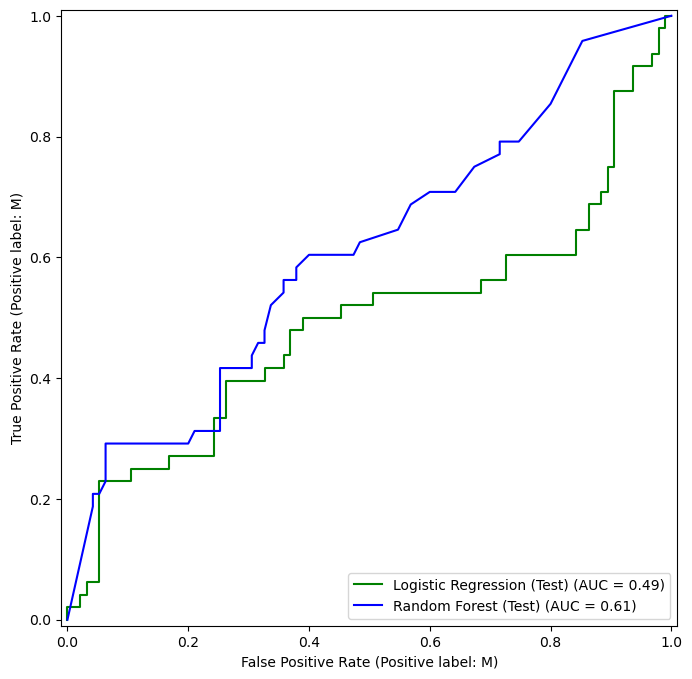

In [62]:
from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
fig, ax = subplots(figsize=(8,8))

roc_curve_est(log_model,
              x_test_log,
              y_test_log,
              name='Logistic Regression (Test)',
              color='g',
              ax=ax);

roc_curve_est(RFC_model,
              x_test_RF,
              y_test_RF,
              name='Random Forest (Test)',
              color='b',
              ax=ax);